In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package stopwords to C:\Users\Raaga
[nltk_data]     Tarunya\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Raaga
[nltk_data]     Tarunya\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!



Top Keywords per Cluster:
Cluster 0: love, bought, old, year, gift, one, tablet, christmas, daughter, got
Cluster 1: easy, use, love, great, set, tablet, product, kid, bought, good
Cluster 2: echo, alexa, show, music, love, great, home, sound, device, light
Cluster 3: kindle, fire, love, book, read, reading, great, new, one, much
Cluster 4: tablet, great, good, price, work, kid, product, like, apps, would


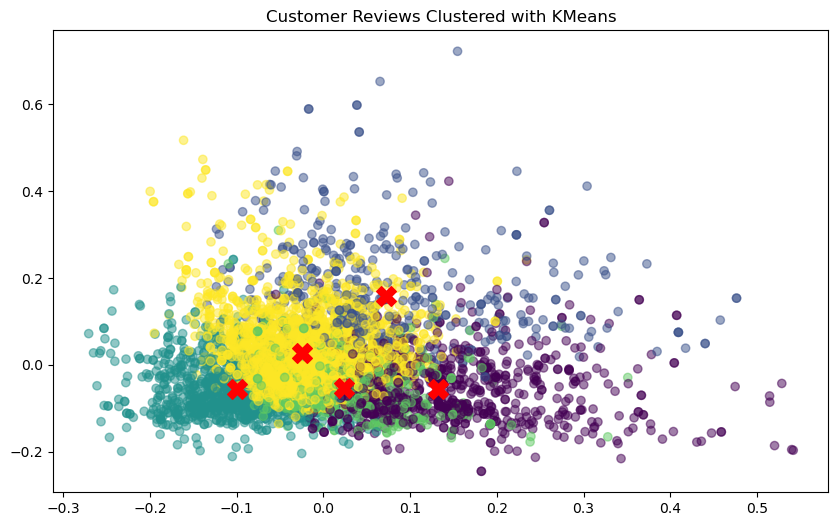


Clustered results saved to clustered_reviews.csv


In [4]:
# Download stopwords if not already
nltk.download('stopwords')
nltk.download('wordnet')

# ----------------------------
# 1. Load Dataset
# ----------------------------
# Example: load CSV (replace with your actual file)
df = pd.read_csv("Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products.csv")

# Use only the review text column
df = df.dropna(subset=['reviews.text'])
reviews = df['reviews.text'].astype(str)

# ----------------------------
# 2. Preprocess Text
# ----------------------------
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def preprocess(text):
    # Lowercase
    text = text.lower()
    # Remove special characters & numbers
    text = re.sub(r'[^a-z\s]', '', text)
    # Tokenize and remove stopwords + lemmatize
    words = [lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words]
    return " ".join(words)

reviews_clean = reviews.apply(preprocess)

# ----------------------------
# 3. Convert to TF-IDF Features
# ----------------------------
vectorizer = TfidfVectorizer(max_features=5000)  # top 5000 words
X = vectorizer.fit_transform(reviews_clean)

# ----------------------------
# 4. Apply KMeans Clustering
# ----------------------------
num_clusters = 5   # you can tune this using elbow method or silhouette score
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
kmeans.fit(X)

# Assign cluster labels to reviews
df['Cluster'] = kmeans.labels_

# ----------------------------
# 5. Extract Top Keywords per Cluster
# ----------------------------
def get_top_keywords(kmeans, vectorizer, n_terms=10):
    terms = vectorizer.get_feature_names_out()
    top_keywords = {}
    for i, center in enumerate(kmeans.cluster_centers_):
        indices = center.argsort()[-n_terms:][::-1]
        top_keywords[i] = [terms[ind] for ind in indices]
    return top_keywords

top_keywords = get_top_keywords(kmeans, vectorizer)
print("\nTop Keywords per Cluster:")
for cluster, keywords in top_keywords.items():
    print(f"Cluster {cluster}: {', '.join(keywords)}")

# ----------------------------
# 6. Visualize Clusters with PCA
# ----------------------------
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(X.toarray())
reduced_cluster_centers = pca.transform(kmeans.cluster_centers_)

plt.figure(figsize=(10,6))
plt.scatter(reduced_features[:,0], reduced_features[:,1], c=kmeans.labels_, cmap="viridis", alpha=0.5)
plt.scatter(reduced_cluster_centers[:,0], reduced_cluster_centers[:,1], c="red", marker="X", s=200)
plt.title("Customer Reviews Clustered with KMeans")
plt.show()

# ----------------------------
# 7. Save Results
# ----------------------------
df.to_csv("clustered_reviews.csv", index=False)
print("\nClustered results saved to clustered_reviews.csv")
